In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import folium
import openrouteservice
from openrouteservice import convert
import math
import pandas as pd
import numpy as np
import decimal
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import requests
from IPython.display import display, clear_output
import random

In [3]:
file_path = "gurugram_data.csv"
data = pd.read_csv(file_path)

In [4]:
data.columns

Index(['id', 'latitude', 'longitude', 'nearest_node', 'degree'], dtype='object')

In [5]:
data.head()

,id,latitude,longitude,nearest_node,degree
0,node,28.461697,77.087018,249350111,4
1,node,28.536270,77.197371,250078367,4
2,node,28.450043,77.063861,9903240504,4
3,node,28.482711,77.107530,251691410,3
4,node,28.491757,77.090856,5228569733,3


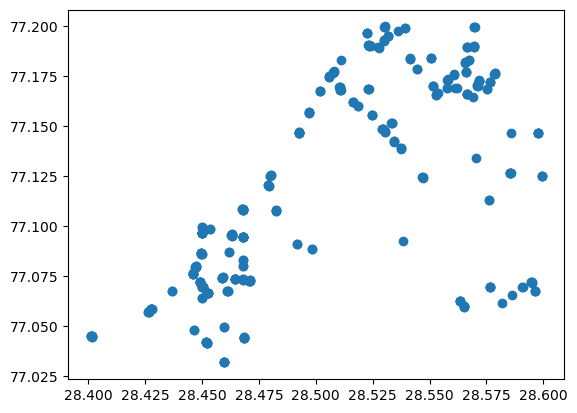

In [6]:
x , y  = data['latitude'] , data['longitude']

plt.scatter(x, y)
plt.show()

In [7]:
coords_path = [[lon, lat] for lon, lat in zip(data['longitude'], data['latitude'])]
n = folium.Map(location=list(reversed([77.09, 28.5])), tiles="cartodbpositron", zoom_start=12)
for coord in coords_path:
    folium.Marker(location=list(reversed(coord))).add_to(n)
n

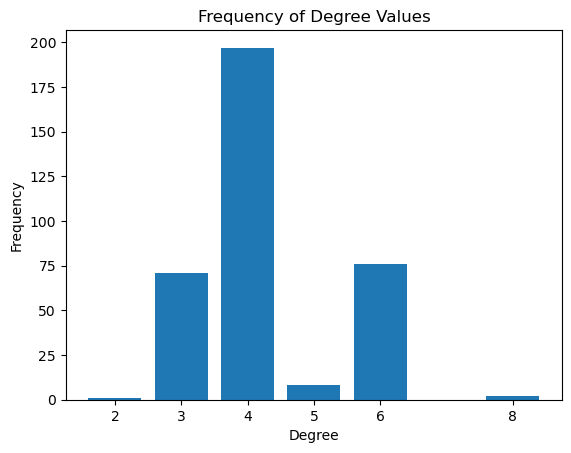

In [8]:
degree_counts = data['degree'].value_counts()

plt.bar(degree_counts.index, degree_counts.values)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Frequency of Degree Values')
plt.xticks(degree_counts.index)

plt.show()

In [9]:
filtered_df = data[data['degree'].isin([5, 6, 8])]
filtered_df

,id,latitude,longitude,nearest_node,degree
17,node,28.458669,77.074044,9501049071,5
24,node,28.585618,77.146488,9794116732,6
30,node,28.575097,77.168516,282138885,6
41,node,28.597626,77.146186,11780481158,5
42,node,28.597724,77.146207,11780481159,6
...,...,...,...,...,...
341,node,28.450235,77.069544,9903465142,6
342,node,28.449102,77.071824,3204210851,6
343,node,28.449283,77.071733,9903465132,6
344,node,28.449296,77.071866,9903465132,6


In [10]:
map_center = [filtered_df['latitude'].mean(), filtered_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

for idx, row in filtered_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Node ID: {row['id']}<br>Degree: {row['degree']}",
        icon=folium.Icon(color='red' if row['degree'] == 8 else 'orange' if row['degree'] == 6 else 'blue')
    ).add_to(m)

m.save('map.html')

# Display map in a Jupyter notebook
m


In [11]:
client = openrouteservice.Client(key='5b3ce3597851110001cf62487dab724e881e4bfeab36d60cd37e61f6')

def get_address(row):
    try:
        coordinates = (row['longitude'], row['latitude'])
        result = client.pelias_reverse(point=coordinates)
        address = result['features'][0]['properties']['label']
        return address
    except Exception as e:
        return str(e)

data['address'] = data.apply(get_address, axis=1)

print("Addresses have been added to the dataset.")

Addresses have been added to the dataset.


In [12]:
data

,id,latitude,longitude,nearest_node,degree,address
0,node,28.461697,77.087018,249350111,4,"Guardian Pharmacy, Gurugram, HR, India"
1,node,28.536270,77.197371,250078367,4,"Krishna Super Marché 37, Delhi, India"
2,node,28.450043,77.063861,9903240504,4,"Vista Wood, Gurugram, HR, India"
3,node,28.482711,77.107530,251691410,3,"Moulsari Road, Gurugram, HR, India"
4,node,28.491757,77.090856,5228569733,3,"Royal Bank of Scotland, Gurugram, HR, India"
...,...,...,...,...,...,...
350,node,28.458890,77.073936,266595943,4,"August Kranti Marg, Gurugram, HR, India"
351,node,28.471020,77.072484,1987622348,4,"August Kranti Marg, Gurugram, HR, India"
352,node,28.498291,77.088351,4135550240,4,"DLF Cyber City, Gurugram, HR, India"
353,node,28.471079,77.072706,6112563505,3,"August Kranti Marg, Gurugram, HR, India"


In [13]:
min_latitude = 28.4291
max_latitude = 28.4592
min_longitude = 77.0367
max_longitude = 77.0725

# Filter the rows within the bounding box
path_points = data[
    (data['latitude'] >= min_latitude) &
    (data['latitude'] <= max_latitude) &
    (data['longitude'] >= min_longitude) &
    (data['longitude'] <= max_longitude)
]


In [14]:
coords_path = [[lon, lat] for lon, lat in zip(path_points['longitude'], path_points['latitude'])]
n = folium.Map(location=list(reversed([77.049466, 28.808122])), tiles="cartodbpositron", zoom_start=12)
for coord in coords_path:
    folium.Marker(location=list(reversed(coord))).add_to(n)
n

In [15]:
api_key = '5b3ce3597851110001cf62487dab724e881e4bfeab36d60cd37e61f6'
client = openrouteservice.Client(key=api_key)

start_coords = (28.4291, 77.0984433)
end_coords = (28.4592, 77.049466)

route = client.directions(coordinates=[(start_coords[1], start_coords[0]), (end_coords[1], end_coords[0])], profile='driving-car', format='geojson')
route_coords = [(coord[1], coord[0]) for coord in route['features'][0]['geometry']['coordinates']]
car_map = folium.Map(location=[start_coords[0], start_coords[1]], zoom_start=14)
folium.GeoJson(route, name='route').add_to(car_map)

folium.Marker(
    location=[start_coords[0], start_coords[1]],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(car_map)

folium.Marker(
    location=[end_coords[0], end_coords[1]],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(car_map)
coords_path = [[lon, lat] for lon, lat in zip(path_points['longitude'], path_points['latitude'])]

distance = route['features'][0]['properties']['segments'][0]['distance'] / 1000
duration = route['features'][0]['properties']['segments'][0]['duration'] / 60

folium.map.Marker(
    [start_coords[0], start_coords[1]],
    icon=folium.DivIcon(
        html=f'<div style="font-size: 16pt">Distance: {distance:.2f} km<br>Duration: {duration:.2f} min</div>'
    )
).add_to(car_map)


car_map.save('car_movement_directions_map.html')

display(car_map)


for i in range(len(route_coords)):
    current_coords = route_coords[i]
    clear_output(wait=True)
    car_map = folium.Map(location=current_coords, zoom_start=14)
    folium.GeoJson(route, name='route').add_to(car_map)
    folium.Marker(
        location=[start_coords[0], start_coords[1]],
        popup='Start',
        icon=folium.Icon(color='green')
    ).add_to(car_map)

    folium.Marker(
        location=[end_coords[0], end_coords[1]],
        popup='End',
        icon=folium.Icon(color='red')
    ).add_to(car_map)

    folium.PolyLine(locations=route_coords[:i+1], color='blue').add_to(car_map)

    speed_limit = random.uniform(50, 52)

    print(f'Current speed limit: {speed_limit:.2f} km/h')

    folium.Marker(
        location=current_coords,
        popup=f'Speed Limit: {speed_limit:.2f} km/h',
        icon=folium.Icon(color='red')
    ).add_to(car_map)

    # Display the map
    display(car_map)

    time.sleep(0.1)


Current speed limit: 50.76 km/h


In [16]:
import folium
import openrouteservice
import random
import time
from IPython.display import display, clear_output

# Initialize OpenRouteService client
api_key = '5b3ce3597851110001cf62487dab724e881e4bfeab36d60cd37e61f6'
client = openrouteservice.Client(key=api_key)

# Define start and end coordinates
start_coords = (28.4291, 77.0984433)
end_coords = (28.4592, 77.049466)

# Get the route
route = client.directions(
    coordinates=[(start_coords[1], start_coords[0]), (end_coords[1], end_coords[0])],
    profile='driving-car',
    format='geojson'
)

# Extract route coordinates
route_coords = [(coord[1], coord[0]) for coord in route['features'][0]['geometry']['coordinates']]

# Initialize folium map
car_map = folium.Map(location=[start_coords[0], start_coords[1]], zoom_start=14)
folium.GeoJson(route, name='route').add_to(car_map)

# Add start and end markers
folium.Marker(
    location=[start_coords[0], start_coords[1]],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(car_map)

folium.Marker(
    location=[end_coords[0], end_coords[1]],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(car_map)

# Add path points markers (with blue color)
for idx, row in path_points.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f'Point {idx}',
        icon=folium.Icon(color='blue')
    ).add_to(car_map)

# Add distance and duration info
distance = route['features'][0]['properties']['segments'][0]['distance'] / 1000
duration = route['features'][0]['properties']['segments'][0]['duration'] / 60

folium.map.Marker(
    [start_coords[0], start_coords[1]],
    icon=folium.DivIcon(
        html=f'<div style="font-size: 16pt">Distance: {distance:.2f} km<br>Duration: {duration:.2f} min</div>'
    )
).add_to(car_map)

# Save the initial map as an HTML file
car_map.save('car_movement_directions_map.html')

# Display the initial map
display(car_map)

# Animate the car movement along the route
for i, current_coords in enumerate(route_coords):
    clear_output(wait=True)
    car_map = folium.Map(location=current_coords, zoom_start=14)
    folium.GeoJson(route, name='route').add_to(car_map)
    folium.Marker(
        location=[start_coords[0], start_coords[1]],
        popup='Start',
        icon=folium.Icon(color='green')
    ).add_to(car_map)

    folium.Marker(
        location=[end_coords[0], end_coords[1]],
        popup='End',
        icon=folium.Icon(color='red')
    ).add_to(car_map)

    folium.PolyLine(locations=route_coords[:i + 1], color='blue').add_to(car_map)

    # Add path points markers again
    for idx, row in path_points.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f'Point {idx}',
            icon=folium.Icon(color='blue')
        ).add_to(car_map)

    # Add speed limit (randomly generated for demonstration)
    speed_limit = random.uniform(50, 52)
    folium.Marker(
        location=current_coords,
        popup=f'Speed Limit: {speed_limit:.2f} km/h',
        icon=folium.Icon(color='red')
    ).add_to(car_map)

    # Display the current frame (optional)
    display(car_map)
    time.sleep(0.1)


In [16]:
import folium
import openrouteservice
import random
import time
from IPython.display import display, clear_output
from geopy.distance import geodesic
import pandas as pd


# Initialize OpenRouteService client
api_key = '5b3ce3597851110001cf62487dab724e881e4bfeab36d60cd37e61f6'
client = openrouteservice.Client(key=api_key)

# Define start and end coordinates
start_coords = (28.4291, 77.0984433)
end_coords = (28.4592, 77.049466)

# Get the route
route = client.directions(
    coordinates=[(start_coords[1], start_coords[0]), (end_coords[1], end_coords[0])],
    profile='driving-car',
    format='geojson'
)

# Extract route coordinates
route_coords = [(coord[1], coord[0]) for coord in route['features'][0]['geometry']['coordinates']]

# Filter path_points that are near the route
def is_near_route(point, route_coords, threshold=0.5):
    """Check if a point is within the threshold distance (in km) of the route."""
    point_lat, point_lon = point
    for route_lat, route_lon in route_coords:
        if geodesic((point_lat, point_lon), (route_lat, route_lon)).km <= threshold:
            return True
    return False

# Threshold distance in km
threshold_distance = 0.5
filtered_path_points = data[
    data.apply(lambda row: is_near_route((row['latitude'], row['longitude']), route_coords, threshold_distance), axis=1)
]

# Initialize folium map
car_map = folium.Map(location=[start_coords[0], start_coords[1]], zoom_start=14)
folium.GeoJson(route, name='route').add_to(car_map)

# Add start and end markers
folium.Marker(
    location=[start_coords[0], start_coords[1]],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(car_map)

folium.Marker(
    location=[end_coords[0], end_coords[1]],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(car_map)

# Add filtered path points markers (with blue color)
for idx, row in filtered_path_points.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f'Point {idx}',
        icon=folium.Icon(color='blue')
    ).add_to(car_map)

# Add distance and duration info
distance = route['features'][0]['properties']['segments'][0]['distance'] / 1000
duration = route['features'][0]['properties']['segments'][0]['duration'] / 60

folium.map.Marker(
    [start_coords[0], start_coords[1]],
    icon=folium.DivIcon(
        html=f'<div style="font-size: 16pt">Distance: {distance:.2f} km<br>Duration: {duration:.2f} min</div>'
    )
).add_to(car_map)

# Save the initial map as an HTML file
car_map.save('car_movement_directions_map.html')

# Display the initial map
display(car_map)

# Animate the car movement along the route
for i, current_coords in enumerate(route_coords):
    clear_output(wait=True)
    car_map = folium.Map(location=current_coords, zoom_start=14)
    folium.GeoJson(route, name='route').add_to(car_map)
    folium.Marker(
        location=[start_coords[0], start_coords[1]],
        popup='Start',
        icon=folium.Icon(color='green')
    ).add_to(car_map)

    folium.Marker(
        location=[end_coords[0], end_coords[1]],
        popup='End',
        icon=folium.Icon(color='red')
    ).add_to(car_map)

    folium.PolyLine(locations=route_coords[:i + 1], color='blue').add_to(car_map)

    # Add filtered path points markers again
    for idx, row in filtered_path_points.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f'Point {idx}',
            icon=folium.Icon(color='blue')
        ).add_to(car_map)

    # Add speed limit (randomly generated for demonstration)
    speed_limit = random.uniform(50, 52)
    folium.Marker(
        location=current_coords,
        popup=f'Speed Limit: {speed_limit:.2f} km/h',
        icon=folium.Icon(color='red')
    ).add_to(car_map)

    # Display the current frame (optional)
    display(car_map)
    time.sleep(0.1)
